## Lending Club Case Study

### Import all required libraries

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
file_path = "loan.csv"
df = pd.read_csv(file_path)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
df.shape

(39717, 111)

### Clean the data
#### i) Remove all variables which has more than 75% null values
#### ii) Remove all customer behavious variables
#### iii) Remove all records with LOAN_STATUS as `Current` since we are focusing on `Fully paid` and `Charged off`

In [4]:
null_percent = 75
null_count = int(((100 - null_percent) / 100) * df.shape[0] + 1)
# axis=1 => columns
# thresh => Delete columns which contains less than minimum thresh number of non-null values.
cleaned_df = df.dropna(axis=1, thresh=null_count)

# Remove customer behaviour variables
behaviour_variables = ["delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "open_acc", "pub_rec", 
                       "revol_bal", "revol_util", "total_acc", "out_prncp", "out_prncp_inv", 
                       "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", 
                       "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", 
                       "last_pymnt_amnt", "last_credit_pull_d", "application_type"]
cleaned_df = cleaned_df.drop(behaviour_variables, axis=1)

# Some variables like url, id, zip_code, desc are not required for analysis
# Other variables like initial_list_status, acc_now_delinq, delinq_amnt, policy_code, pymnt_plan have single value, so they are not useful
# 64% missing value for mths_since_last_delinq, lets remove that varable
other_extra_variables = ["url", "id", "emp_title", "zip_code", "initial_list_status", "acc_now_delinq", "delinq_amnt", 
                       "tax_liens", "policy_code", "desc", "title", "pymnt_plan", "mths_since_last_delinq"]
cleaned_df = cleaned_df.drop(other_extra_variables, axis=1)

# Remove Current loan_status 
filtered_df = cleaned_df[cleaned_df["loan_status"] != "Current"]

filtered_df.shape

(38577, 21)

## Data Transformation
#### i) Check if loan_amnt is numeric
#### ii) Check if funded_amnt is numeric
#### iii) Check if annual_inc is numeric
#### vi) Check if funded_amnt_inv is numeric
#### v) Check if member_id is numeric and unique

In [5]:
print("loan_amnt - is numeric - ", is_numeric_dtype(filtered_df["loan_amnt"]), 
      "\nfunded_amnt - is numeric - ", is_numeric_dtype(filtered_df["funded_amnt"]),
      "\nannual_inc - is numeric - ", is_numeric_dtype(filtered_df["annual_inc"]),
      "\nfunded_amnt_inv - is numeric - ", is_numeric_dtype(filtered_df["funded_amnt_inv"]),
      "\nmember_id - is numeric - ", is_numeric_dtype(filtered_df["member_id"]), 
      "\nmember_id - is unique - ", filtered_df["member_id"].is_unique)

# Use 'df[variable].astype(dtype)' to cast if required

loan_amnt - is numeric -  True 
funded_amnt - is numeric -  True 
annual_inc - is numeric -  True 
funded_amnt_inv - is numeric -  True 
member_id - is numeric -  True 
member_id - is unique -  True


#### vi) Remove % from int_rate
#### vii) Extract only numbers from emp_length
#### viii) Extract year from issue_year
#### ix) Transform loan_status values to 0 / 1

In [6]:
# Remove % from int_rate 
filtered_df["int_rate"] = filtered_df["int_rate"].str.replace("%", "", regex=True).astype('float')

# Extract only integer from emp_length
filtered_df["emp_length"] = filtered_df.emp_length.str.extract('(\d+)')

# Extract only year from issue_d
filtered_df["issue_year"] = filtered_df.issue_d.str.extract('(\d+)')

# Transform loan_status values to 0 / 1 => Fully Pain = 1, Charged off = 0
filtered_df['loan_status'] = np.where(filtered_df['loan_status'] == "Fully Paid", 1, 0)

In [7]:
# Check distinct vaues for term
filtered_df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
# Remove space
filtered_df['term'] = filtered_df.term.str.strip()

In [9]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   member_id                   38577 non-null  int64  
 1   loan_amnt                   38577 non-null  int64  
 2   funded_amnt                 38577 non-null  int64  
 3   funded_amnt_inv             38577 non-null  float64
 4   term                        38577 non-null  object 
 5   int_rate                    38577 non-null  float64
 6   installment                 38577 non-null  float64
 7   grade                       38577 non-null  object 
 8   sub_grade                   38577 non-null  object 
 9   emp_length                  37544 non-null  object 
 10  home_ownership              38577 non-null  object 
 11  annual_inc                  38577 non-null  float64
 12  verification_status         38577 non-null  object 
 13  issue_d                     385

### Missing values Imputation

In [10]:
percent_missing = filtered_df.isnull().sum() * 100 / len(filtered_df)
percent_missing

member_id                     0.000000
loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_length                    2.677761
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
purpose                       0.000000
addr_state                    0.000000
dti                           0.000000
collections_12_mths_ex_med    0.145164
chargeoff_within_12_mths      0.145164
pub_rec_bankruptcies          1.806776
issue_year                    0.000000
dtype: float64

#### To impute missing values, we an use
#### 1. `median` for emp_length
#### 2. `mod` for pub_rec_bankruptcies

In [11]:
filtered_df.shape

(38577, 22)

## Create bins for int_rate, annual_income and loan_amnt to calculate percentages
#### Used pandas qcut(quantile cut) library to segregate a range of values to a specific bin

In [12]:
print(filtered_df.int_rate.min())
print(filtered_df.int_rate.max())

5.42
24.4


In [13]:
pd.qcut(filtered_df.int_rate, q=5) # q is number of bins

0          (7.9, 10.99]
1         (15.21, 24.4]
2         (15.21, 24.4]
3        (12.84, 15.21]
5          (5.419, 7.9]
              ...      
39712      (7.9, 10.99]
39713      (7.9, 10.99]
39714      (7.9, 10.99]
39715      (5.419, 7.9]
39716    (12.84, 15.21]
Name: int_rate, Length: 38577, dtype: category
Categories (5, interval[float64]): [(5.419, 7.9] < (7.9, 10.99] < (10.99, 12.84] < (12.84, 15.21] < (15.21, 24.4]]

In [14]:
# Get Categories from above qcut and assign them as labels
filtered_df["int_rate_range"] = pd.qcut(filtered_df.int_rate, q=5, 
                                        labels=["5.4-7.9", "7.9-10.9", "10.9-12.8", "12.8-15.2", "15.2-24.4"])

In [15]:
print(filtered_df.annual_inc.min())
print(filtered_df.annual_inc.max())

4000.0
6000000.0


In [16]:
pd.qcut(filtered_df.annual_inc, q=5) # q is number of bins

0        (3999.999, 37196.16]
1        (3999.999, 37196.16]
2        (3999.999, 37196.16]
3         (37196.16, 50004.0]
5        (3999.999, 37196.16]
                 ...         
39712    (90000.0, 6000000.0]
39713    (3999.999, 37196.16]
39714    (90000.0, 6000000.0]
39715    (90000.0, 6000000.0]
39716    (3999.999, 37196.16]
Name: annual_inc, Length: 38577, dtype: category
Categories (5, interval[float64]): [(3999.999, 37196.16] < (37196.16, 50004.0] < (50004.0, 65004.0] < (65004.0, 90000.0] < (90000.0, 6000000.0]]

In [17]:
# Get Categories from above qcut and assign them as labels
filtered_df["annual_inc_range"] = pd.qcut(filtered_df.annual_inc, q=5, 
                                        labels=["4000-37196", "37196-50004", "50004-65004", "65004-90000", "90000-6000000"])

In [18]:
print(filtered_df.loan_amnt.min())
print(filtered_df.loan_amnt.max())

500
35000


In [19]:
pd.qcut(filtered_df.loan_amnt, q=5) # q is number of bins

0        (499.999, 5000.0]
1        (499.999, 5000.0]
2        (499.999, 5000.0]
3        (7750.0, 11200.0]
5        (499.999, 5000.0]
               ...        
39712    (499.999, 5000.0]
39713    (7750.0, 11200.0]
39714    (499.999, 5000.0]
39715    (499.999, 5000.0]
39716     (5000.0, 7750.0]
Name: loan_amnt, Length: 38577, dtype: category
Categories (5, interval[float64]): [(499.999, 5000.0] < (5000.0, 7750.0] < (7750.0, 11200.0] < (11200.0, 16000.0] < (16000.0, 35000.0]]

In [20]:
# Get Categories from above qcut and assign them as labels
filtered_df["loan_amnt_range"] = pd.qcut(filtered_df.loan_amnt, q=5, 
                                        labels=["500-5000", "5000-7750", "7750-11200", "11200-16000", "16000-35000"])

### Calculate percentage for variables which are required for analysis

In [21]:
def calculate_charged_off_percentage(filtered_df, col_name):
    """
    Calculate charged off percentage for a list of columns
    :param filtered_df: input dataframe
    :param col_name: column name for which percentage need to be calculated
    :return filtered_df: dataframe with new columns
    """
    # charged_off_perc = (total row count for col_name with loan_status=charged_off *100)/(total row count for col_name)
    total_col_cnt = filtered_df.groupby(by=[col_name])[col_name].count()
    charged_off_cnt = filtered_df[filtered_df["loan_status"] == 0].groupby(by=[col_name])[col_name].count()
    
    data = {"total_cnt": total_col_cnt, "charged_off_cnt": charged_off_cnt}
    col_df = pd.concat(data, axis = 1) # Create a new dataframe   
    new_col_name = col_name+"_chargedoff_perc"
    col_df[new_col_name] = (col_df.charged_off_cnt*100)/col_df.total_cnt
    col_df = col_df.sort_values(new_col_name, ascending=False).drop(["total_cnt", "charged_off_cnt"], axis=1)
    
    filtered_df = filtered_df.join(col_df, on=[col_name]) # Join new dataframe to filtered_df
    return filtered_df

In [22]:
col_list_for_analysis = ["term", "home_ownership", "emp_length", "addr_state", "grade", "purpose", 
                         "issue_year", "pub_rec_bankruptcies", "loan_amnt_range", "annual_inc_range", 
                         "int_rate_range", "verification_status"]
for col_name in col_list_for_analysis:
    filtered_df = calculate_charged_off_percentage(filtered_df, col_name)

In [23]:
filtered_df.shape

(38577, 37)

## Analysis / Observations

In [24]:
filtered_df.groupby(['loan_status'])['member_id'].count()

loan_status
0     5627
1    32950
Name: member_id, dtype: int64

#### Observation from the above query: Total number of Charged off records are 5627 and Total number of Pully Paid records are 32950

#### issue_year (derived variable)

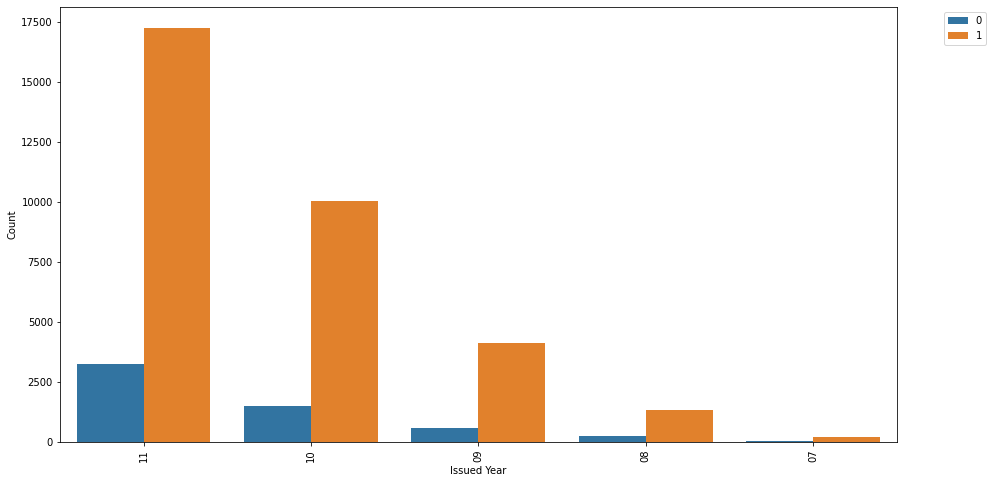

In [25]:
plt.figure(figsize=(15,8))
sns.countplot("issue_year", data=filtered_df, hue=filtered_df['loan_status'])
plt.xlabel("Issued Year")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Number of Loans approved increasing every year

### Univariate Analysis 
#### 1) addr_state

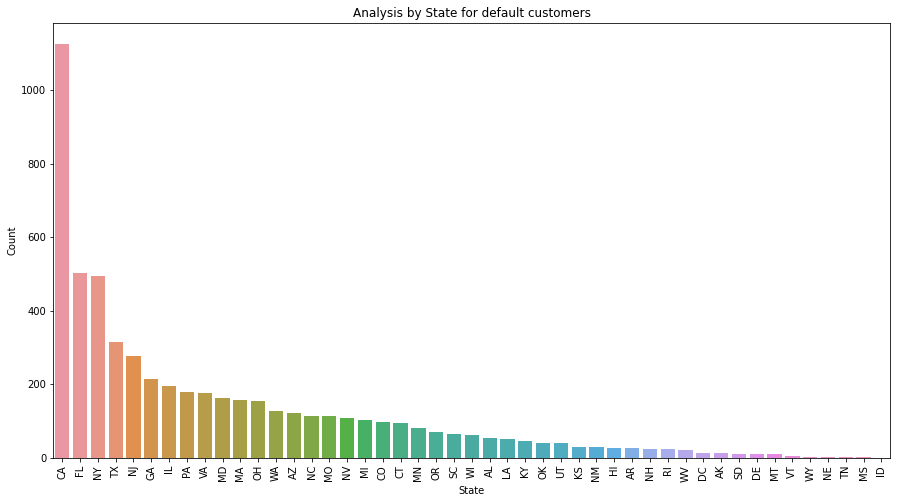

In [26]:
plt.figure(figsize=(15,8))
sns.countplot("addr_state", data=filtered_df[filtered_df['loan_status']== 0], 
              order = filtered_df[filtered_df['loan_status']== 0]["addr_state"].value_counts().index)
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Analysis by State for default customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Most default customers belong to the state CA

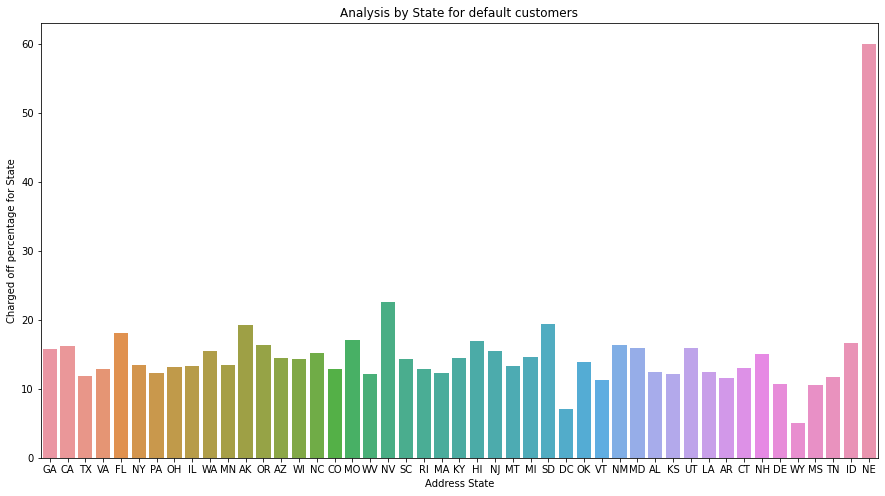

In [27]:
plt.figure(figsize=(15,8))
sns.barplot(x="addr_state", y="addr_state_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Address State")
plt.ylabel("Charged off percentage for State")
plt.title("Analysis by State for default customers")
plt.show()

#### Observation from the above chart: Percentage of default custmers is more in the state NE

#### 2) Term

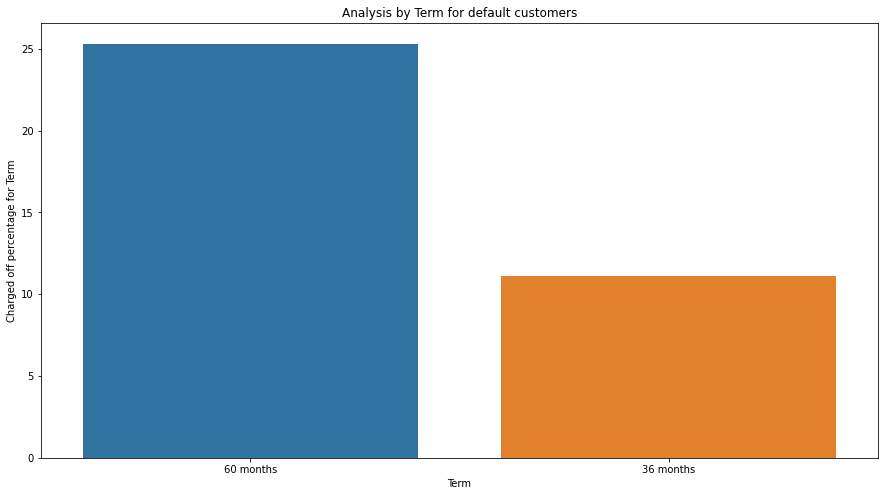

In [28]:
plt.figure(figsize=(15,8))
sns.barplot(x="term", y="term_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Term")
plt.ylabel("Charged off percentage for Term")
plt.title("Analysis by Term for default customers")
plt.show()

#### Observation from the above chart: Percentage of default custmers tenure is more in 60 months term

#### 3) Purpose

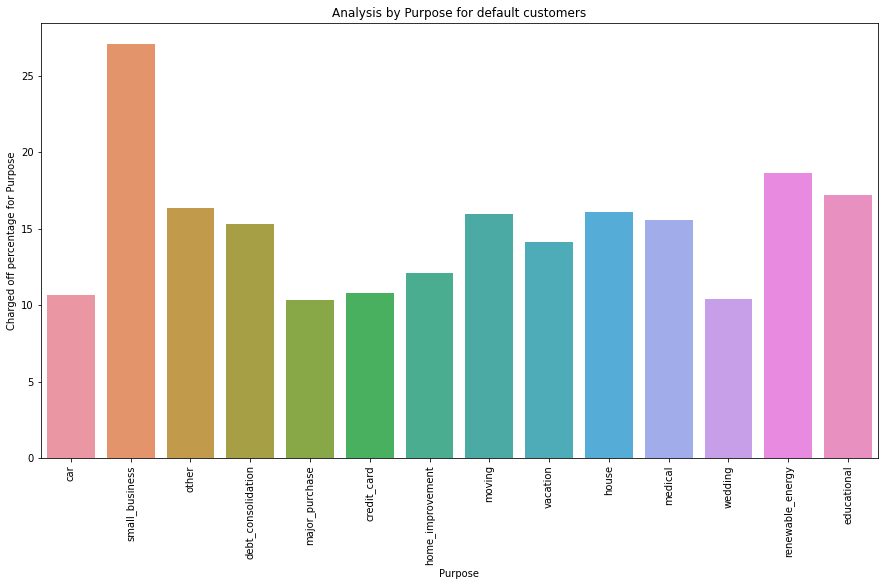

In [29]:
plt.figure(figsize=(15,8))
sns.barplot(x="purpose", y="purpose_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Purpose")
plt.ylabel("Charged off percentage for Purpose")
plt.title("Analysis by Purpose for default customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer's purpose to borrow money is for `small business`

#### 4) Home_ownership

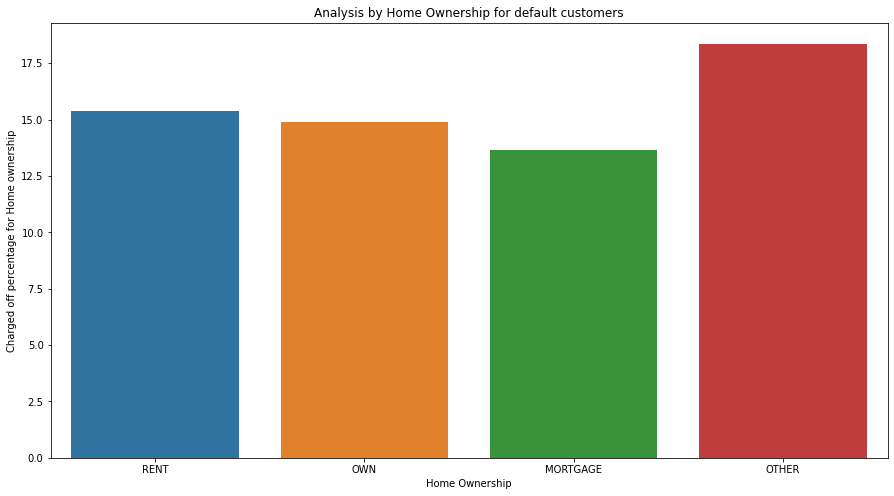

In [30]:
plt.figure(figsize=(15,8))
sns.barplot(x="home_ownership", y="home_ownership_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Home Ownership")
plt.ylabel("Charged off percentage for Home ownership")
plt.title("Analysis by Home Ownership for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer's home_ownership category is `Other`

#### 5) Grade

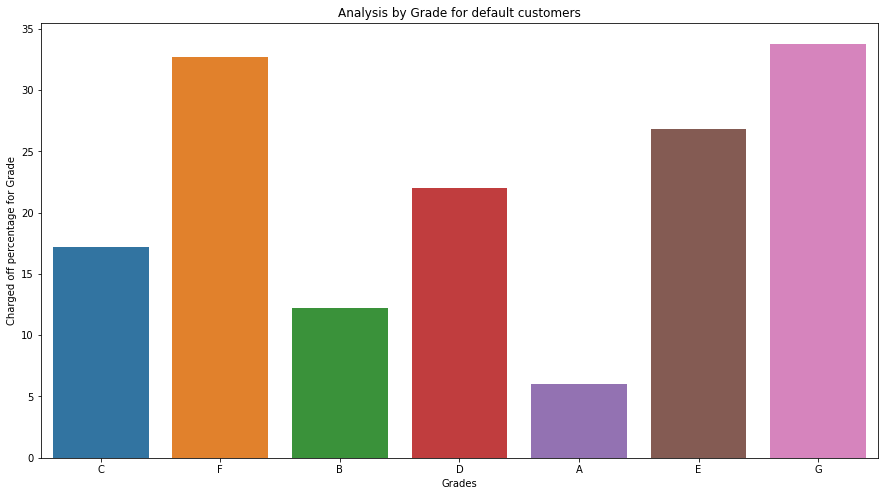

In [31]:
plt.figure(figsize=(15,8))
sns.barplot(x="grade", y="grade_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.ylabel("Charged off percentage for Grade")
plt.xlabel("Grades")
plt.title("Analysis by Grade for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmers belong to the grade `G` and `F`

#### issue_year (derived variable)

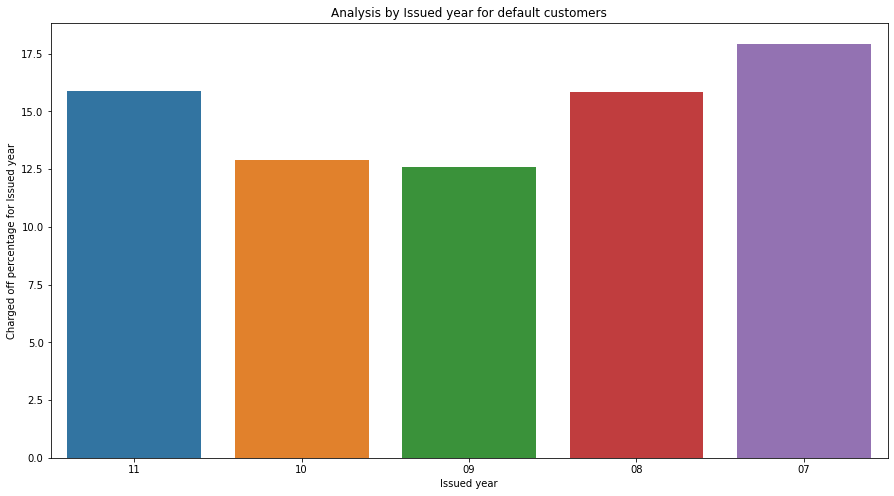

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(x="issue_year", y="issue_year_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Issued year")
plt.ylabel("Charged off percentage for Issued year")
plt.title("Analysis by Issued year for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer didnt repay in the year of 2007

#### 6) emp_length

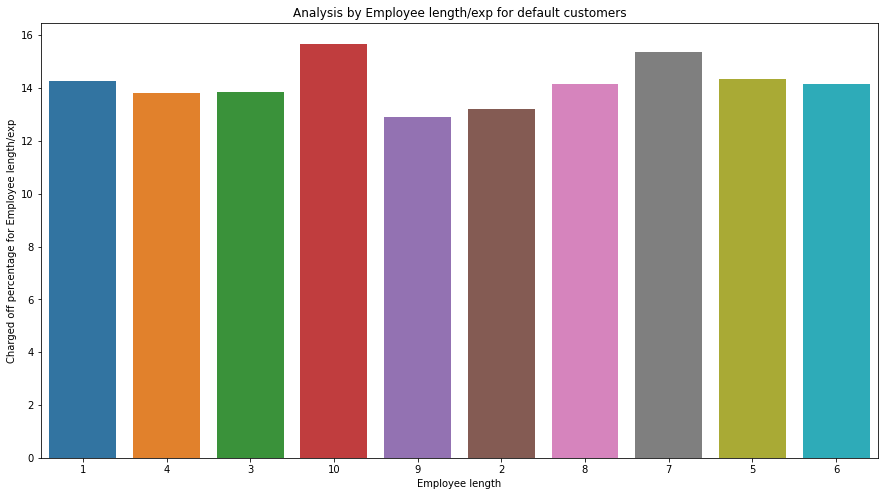

In [33]:
plt.figure(figsize=(15,8))
sns.barplot(x="emp_length", y="emp_length_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Employee length")
plt.ylabel("Charged off percentage for Employee length/exp")
plt.title("Analysis by Employee length/exp for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmers have work experiance of 10/10+ years

#### 7) pub_rec_bankruptcies

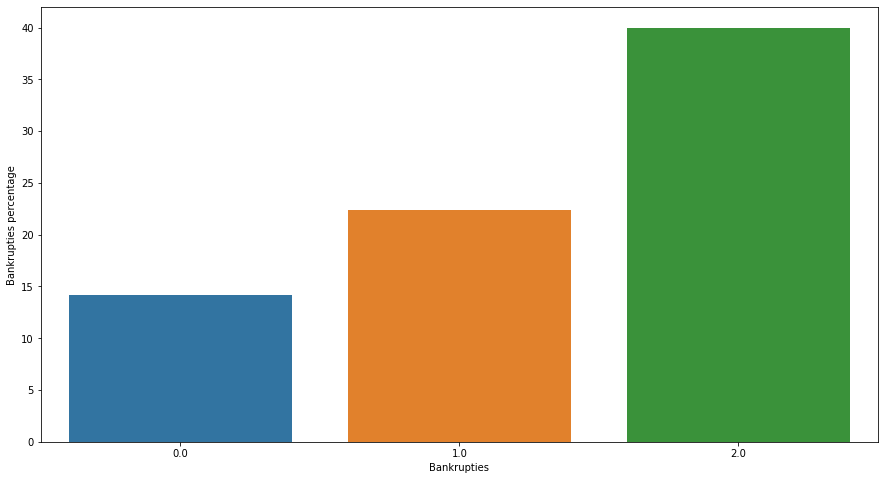

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(x="pub_rec_bankruptcies", y="pub_rec_bankruptcies_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Bankrupties")
plt.ylabel("Bankrupties percentage")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmers have 2 public bankrupt records

#### 8) Annual Income

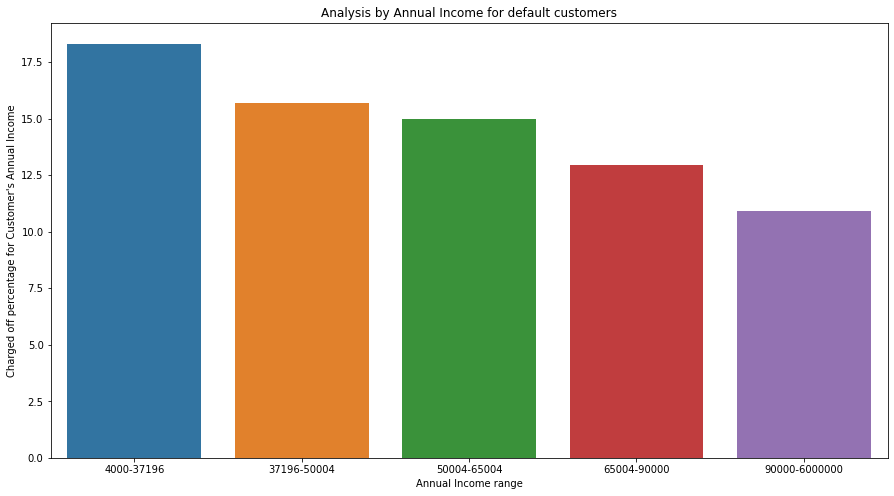

In [35]:
plt.figure(figsize=(15,8))
sns.barplot(x="annual_inc_range", y="annual_inc_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Annual Income range")
plt.ylabel("Charged off percentage for Customer's Annual Income")
plt.title("Analysis by Annual Income for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer's annual income falls between 4k and 37k

#### 9) Interest rate

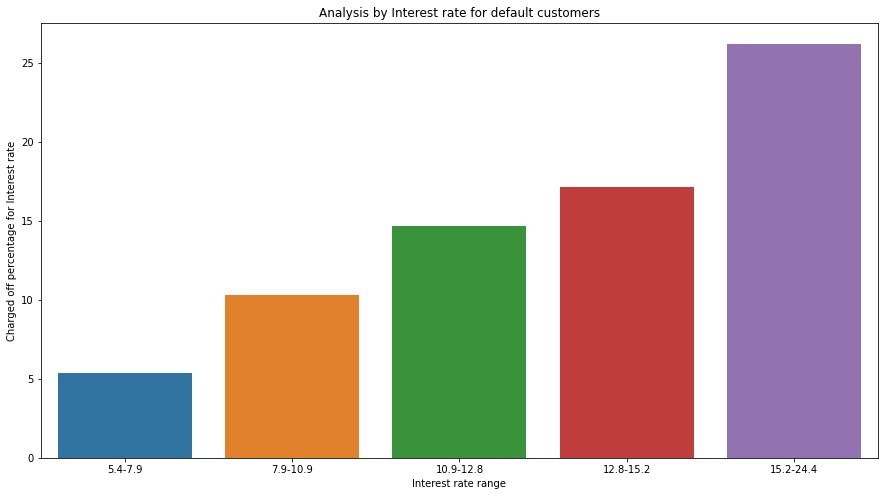

In [36]:
plt.figure(figsize=(15,8))
sns.barplot(x="int_rate_range", y="int_rate_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Interest rate range")
plt.ylabel("Charged off percentage for Interest rate")
plt.title("Analysis by Interest rate for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer's loan interest rate falls between 15% to 24%

#### 10) Loan amount

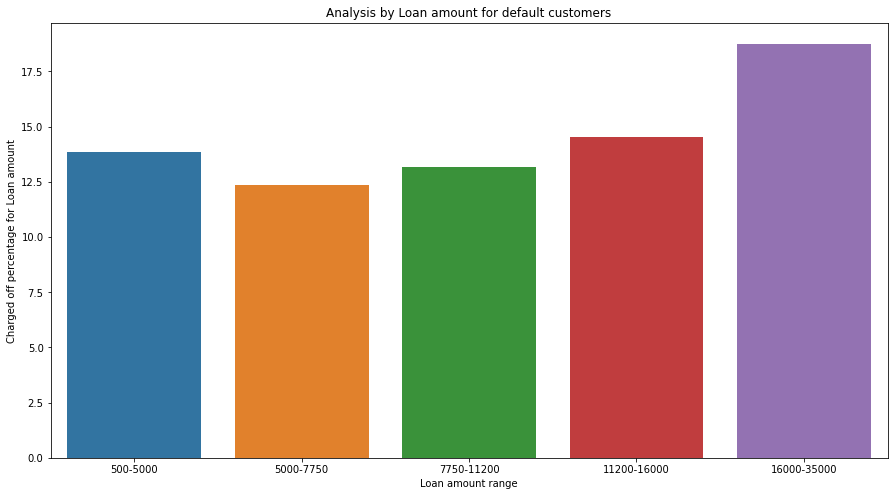

In [37]:
plt.figure(figsize=(15,8))
sns.barplot(x="loan_amnt_range", y="loan_amnt_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Loan amount range")
plt.ylabel("Charged off percentage for Loan amount")
plt.title("Analysis by Loan amount for default customers")
plt.show()

#### Observation from the above chart: Larger Percentage of default custmer's loan amount falls between 16k to 35k

#### 11) Verification status

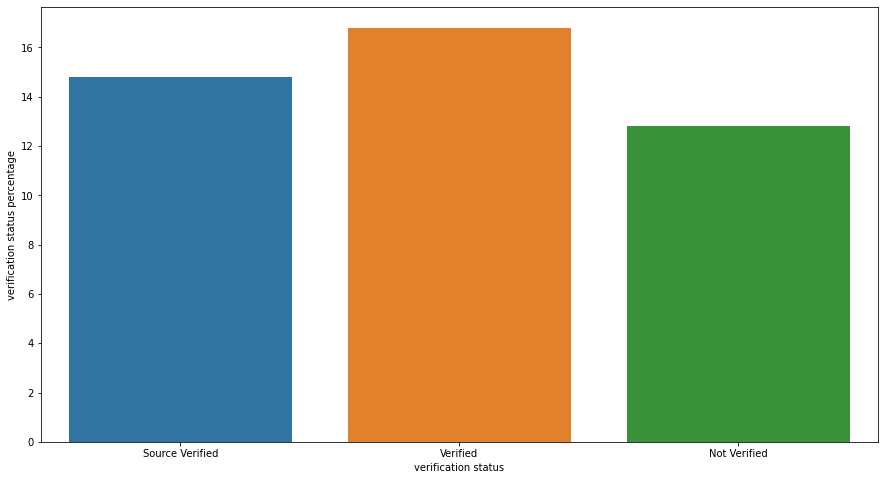

In [38]:
plt.figure(figsize=(15,8))
sns.barplot(x="verification_status", y="verification_status_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("verification status")
plt.ylabel("verification status percentage")
plt.show()

### Bivariate Analysis 
#### 1) loan amount & home_ownership

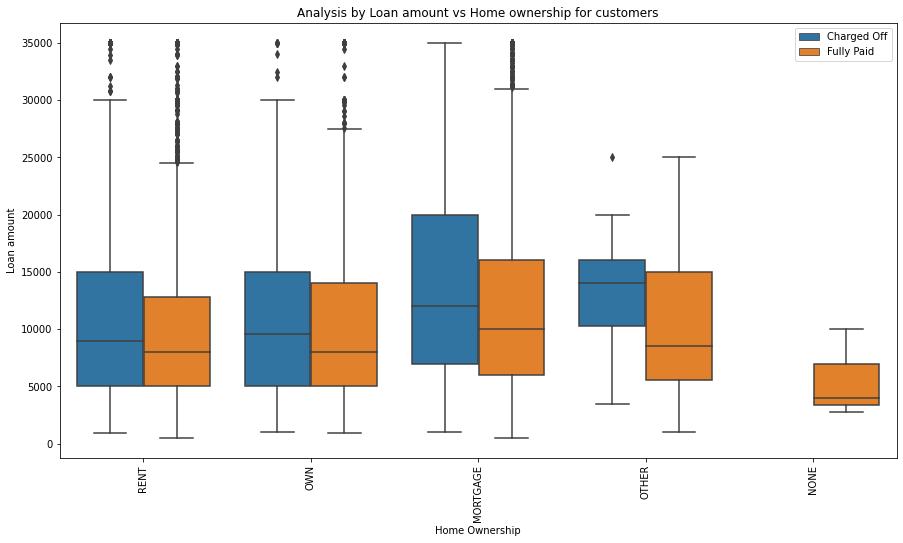

In [39]:
plt.figure(figsize=(15,8))
sns.boxplot(y="loan_amnt", x="home_ownership", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
# print(L.get_texts()[0]) 0=>Charged Off
# print(L.get_texts()[1]) 1=>Fully Paid
plt.xlabel("Home Ownership")
plt.ylabel("Loan amount")
plt.title("Analysis by Loan amount vs Home ownership for customers")
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In default customers, Customers whose home_ownership is MORTGAGE took more loan amount

#### 2) Loan amount & purpose

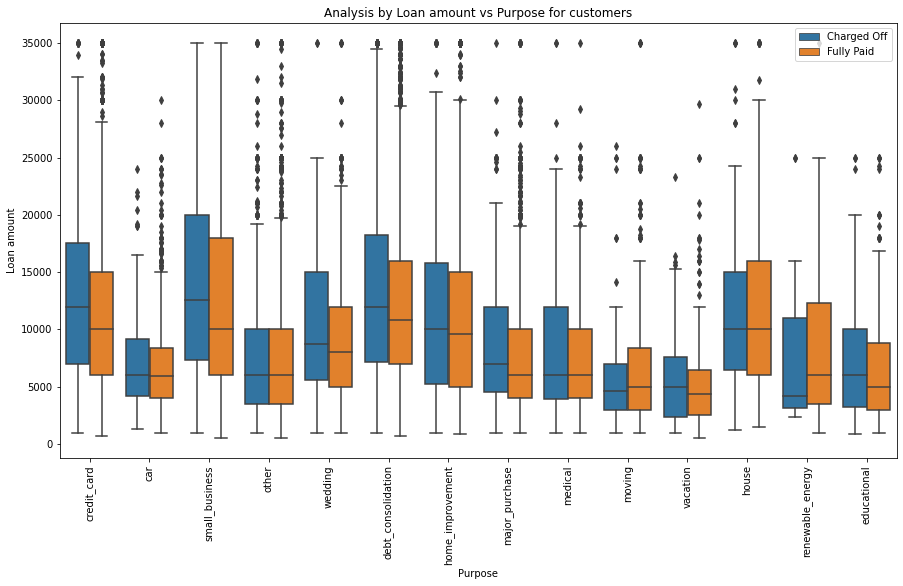

In [40]:
plt.figure(figsize=(15,8))
sns.boxplot(y="loan_amnt", x="purpose", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xlabel("Purpose")
plt.ylabel("Loan amount")
plt.title("Analysis by Loan amount vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In default customers, Customers whose purpose is `small_business` took more loan amount

#### 3) Annual income & purpose

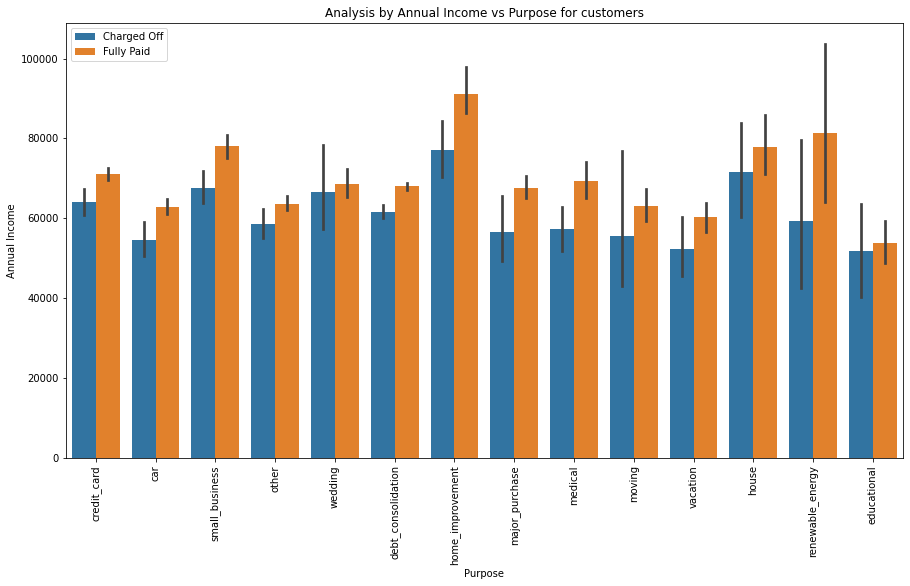

In [41]:
plt.figure(figsize=(15,8))
sns.barplot(y="annual_inc", x="purpose", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xlabel("Purpose")
plt.ylabel("Annual Income")
plt.title("Analysis by Annual Income vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In default customers, Customers with more annual income took loan for home_improvement

#### 4) Interest rate & purpose

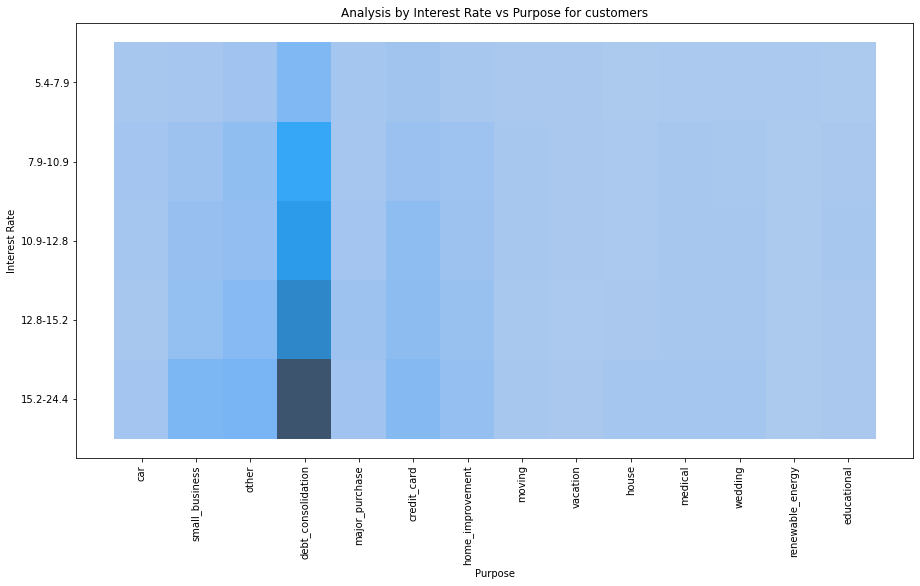

In [42]:
plt.figure(figsize=(15,8))
sns.histplot(y="int_rate_range", x="purpose", data=filtered_df[filtered_df["loan_status"]==0])
plt.xlabel("Purpose")
plt.ylabel("Interest Rate")
plt.title("Analysis by Interest Rate vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In default customers, Customers have taken more loans with high interest rate for `debt consolidation`